In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import shap

In [2]:
!pip install artemis
!pip install pyartemis

from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod
import random

In [3]:
!pip install catboost

from catboost import CatBoostClassifier

In [4]:
data=pd.read_csv('/content/heart_statlog_cleveland_hungary_final.csv')
data.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [5]:
data.isnull().sum()

,0
age,0
sex,0
chest pain type,0
resting bp s,0
cholesterol,0
fasting blood sugar,0
resting ecg,0
max heart rate,0
exercise angina,0
oldpeak,0


In [6]:
print(data.duplicated().sum())

272


In [7]:
data.shape

(1190, 12)

In [8]:
data.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,3.232773,132.153782,210.363866,0.213445,0.698319,139.732773,0.387395,0.922773,1.624370,0.528571
std,9.358203,0.424884,0.935480,18.368823,101.420489,0.409912,0.870359,25.517636,0.487360,1.086337,0.610459,0.499393
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,188.000000,0.000000,0.000000,121.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,229.000000,0.000000,0.000000,140.500000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,269.750000,0.000000,2.000000,160.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


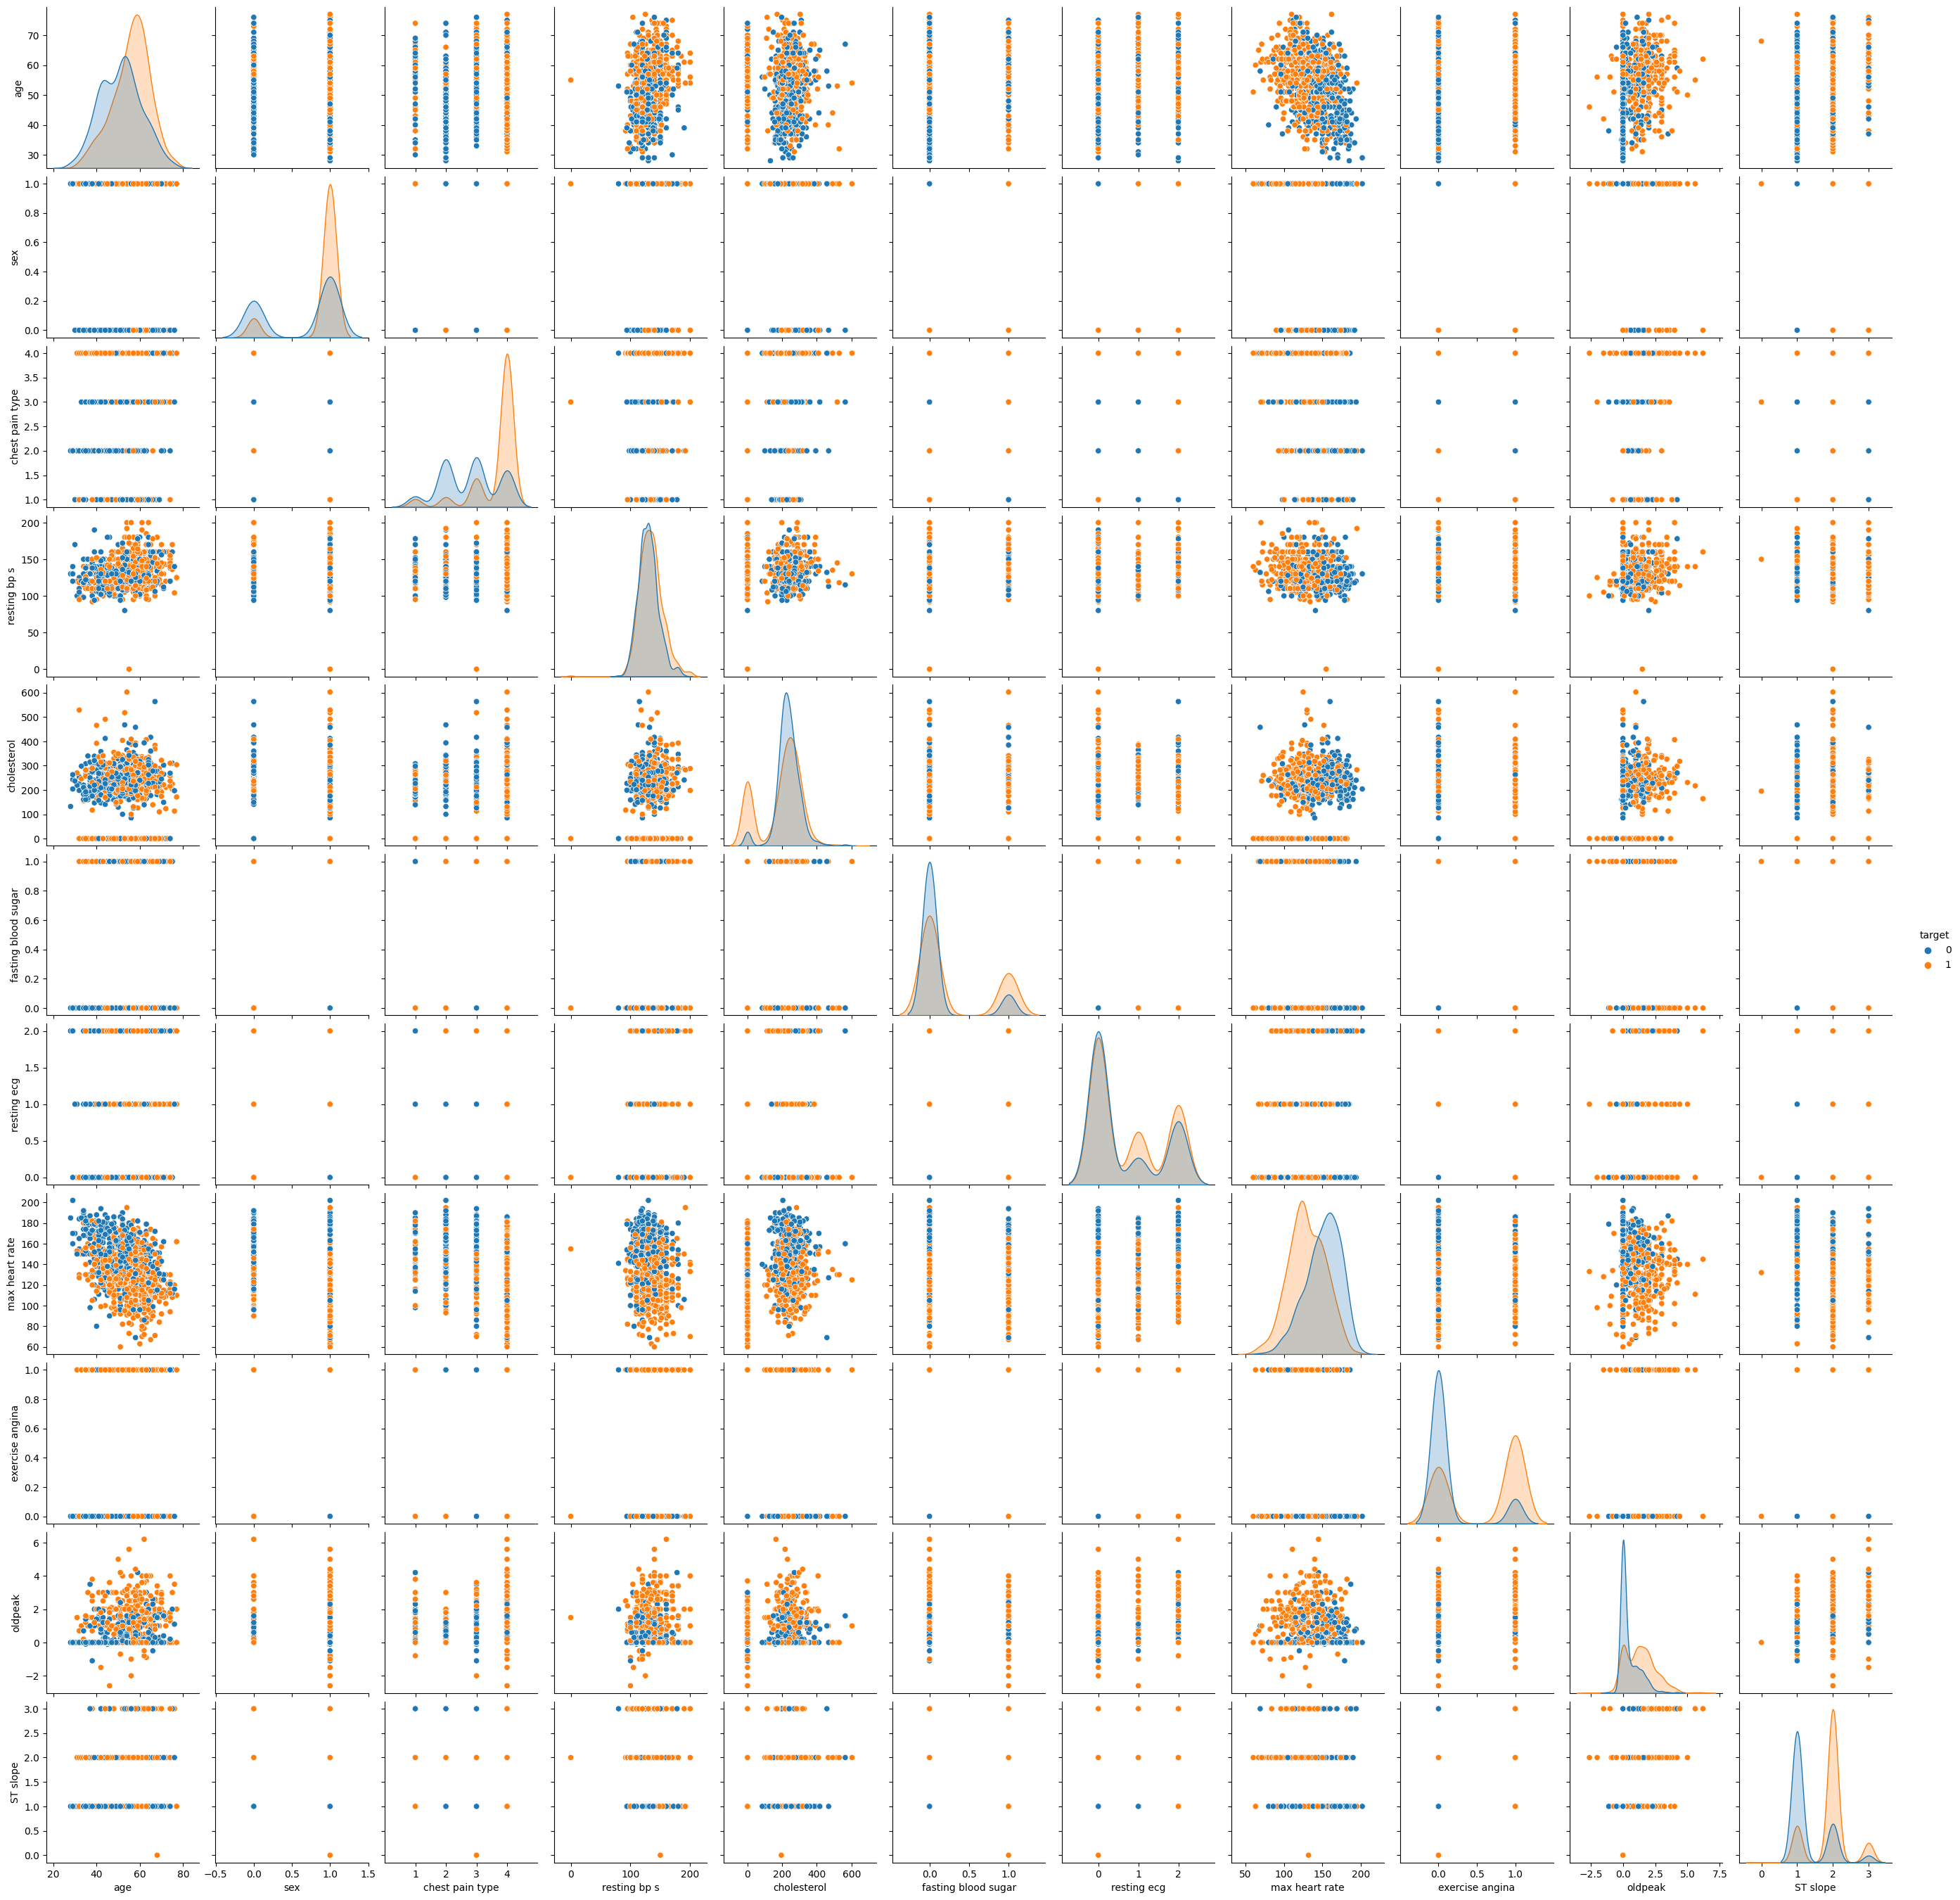

In [9]:
sns.pairplot(data,hue='target')
plt.show()

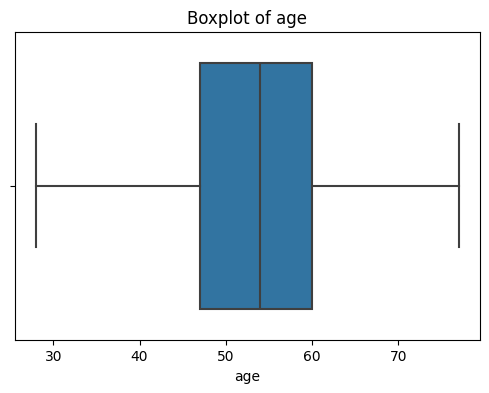

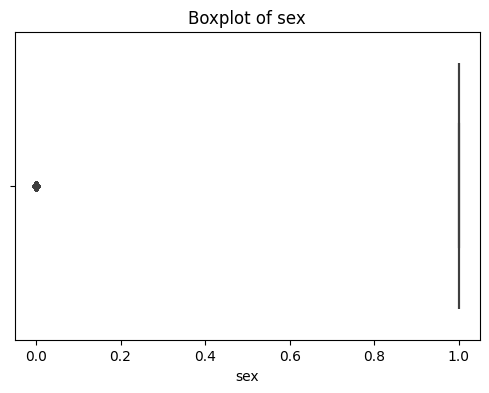

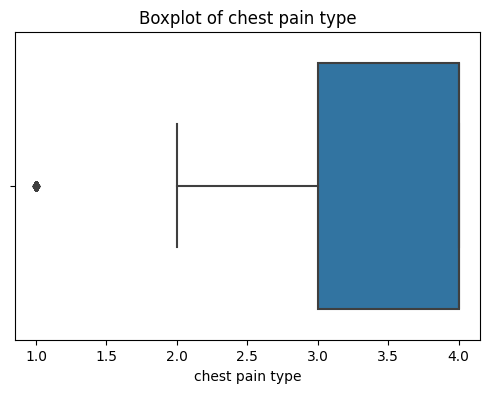

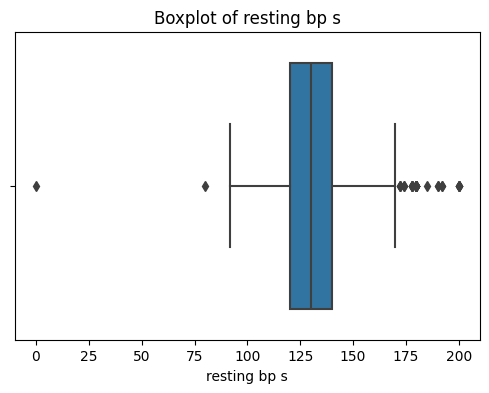

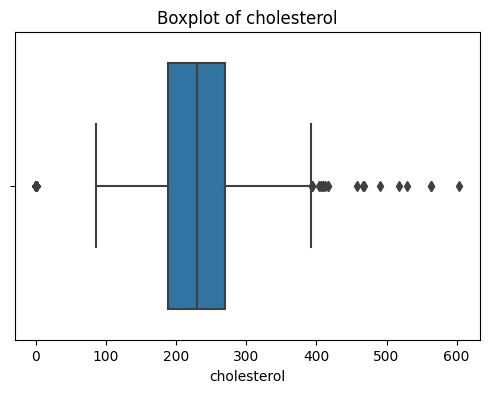

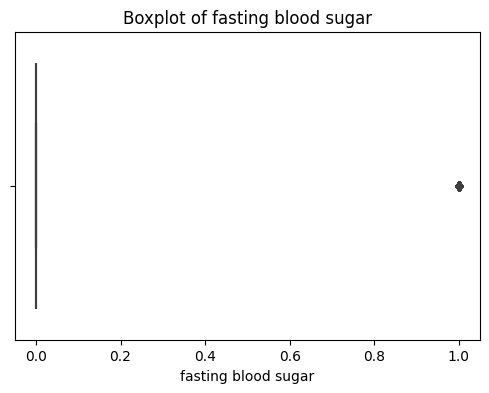

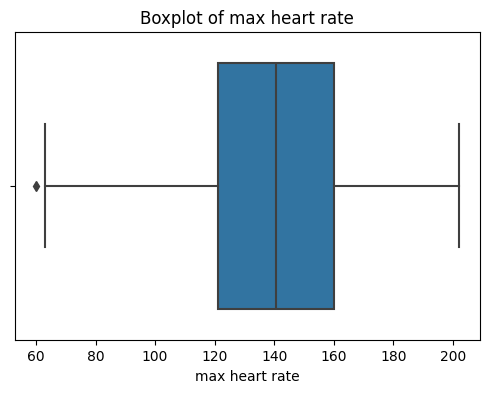

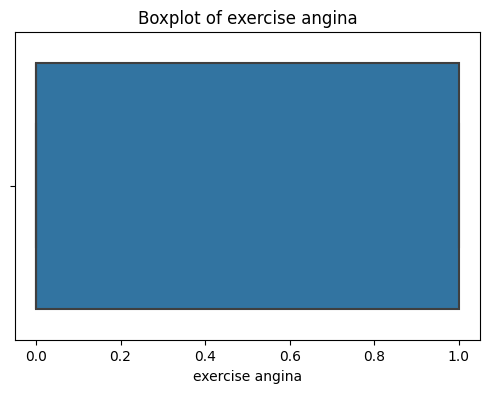

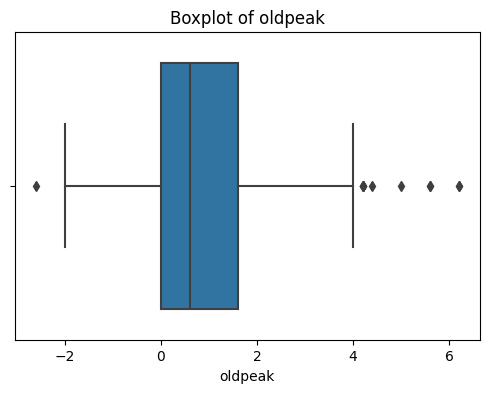

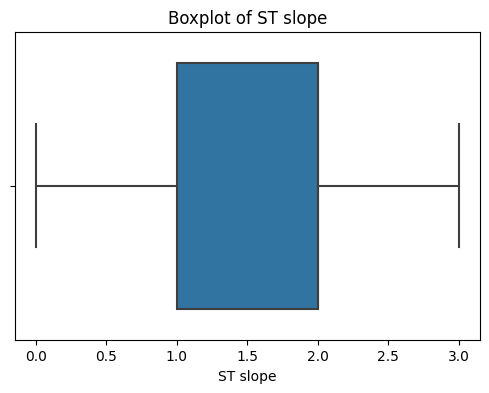

In [10]:
exclude_columns = ['target', 'excercise angina', 'resting ecg']
features = data.select_dtypes(include=['number']).columns
numerical_features = features.drop(exclude_columns, errors='ignore')

for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

In [11]:
Q1 = data[numerical_features].quantile(0.25)
Q3 = data[numerical_features].quantile(0.75)
IQR = Q3 - Q1
outliers=(data[numerical_features] < (Q1 - 1.5 * IQR)) | (data[numerical_features] > (Q3 + 1.5 * IQR))
print(outliers.sum())

age                      0
sex                    281
chest pain type         66
resting bp s            37
cholesterol            193
fasting blood sugar    254
max heart rate           1
exercise angina          0
oldpeak                 11
ST slope                 0
dtype: int64


In [12]:
data.columns

Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope', 'target'],
      dtype='object')

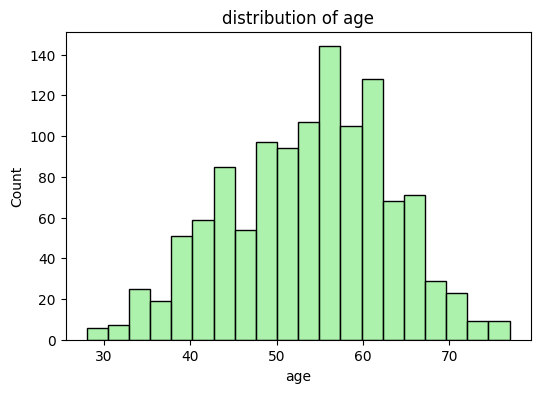

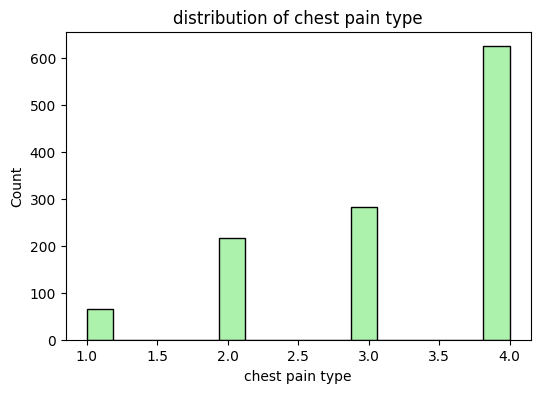

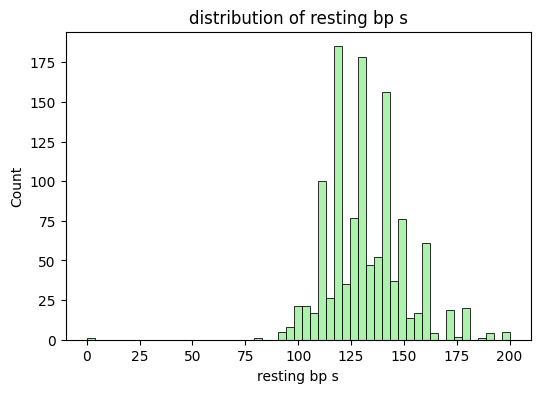

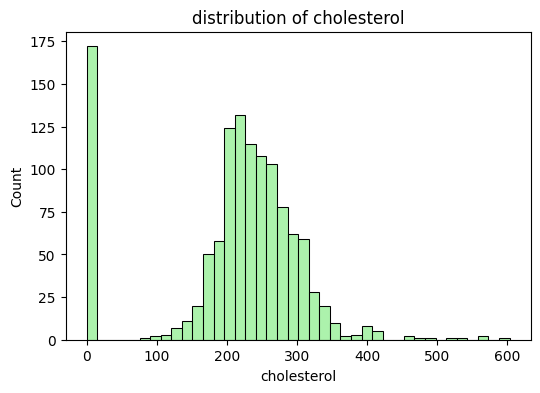

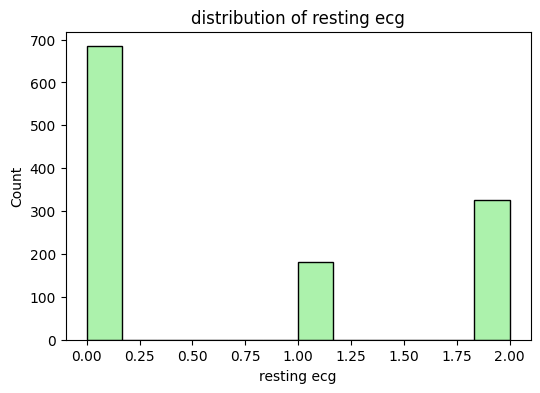

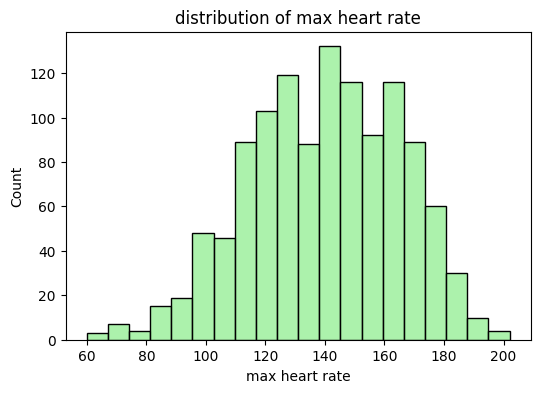

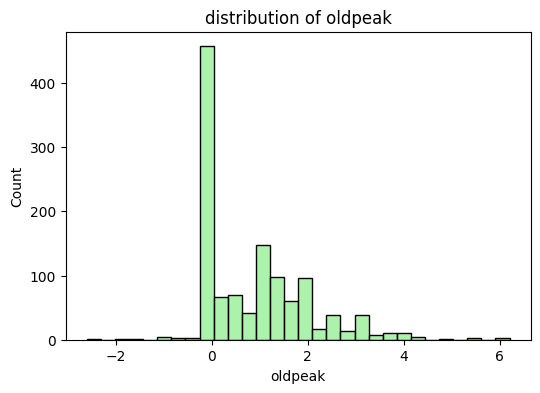

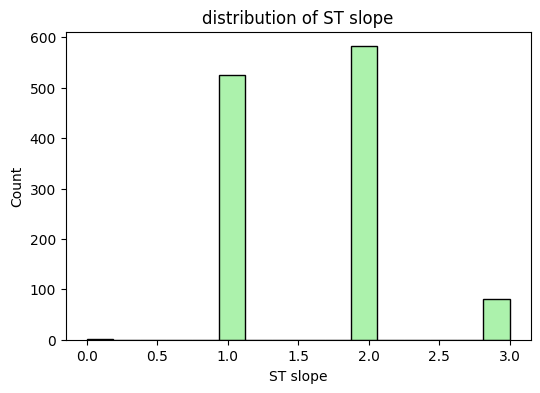

In [13]:
features=['age','chest pain type', 'resting bp s', 'cholesterol', 'resting ecg', 'max heart rate', 'oldpeak', 'ST slope']
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(x=data[feature],color='lightgreen')
    plt.title(f'distribution of {feature}')
    plt.show()

In [14]:
data[features].head()

,age,chest pain type,resting bp s,cholesterol,resting ecg,max heart rate,oldpeak,ST slope
0,40,2,140,289,0,172,0.0,1
1,49,3,160,180,0,156,1.0,2
2,37,2,130,283,1,98,0.0,1
3,48,4,138,214,0,108,1.5,2
4,54,3,150,195,0,122,0.0,1


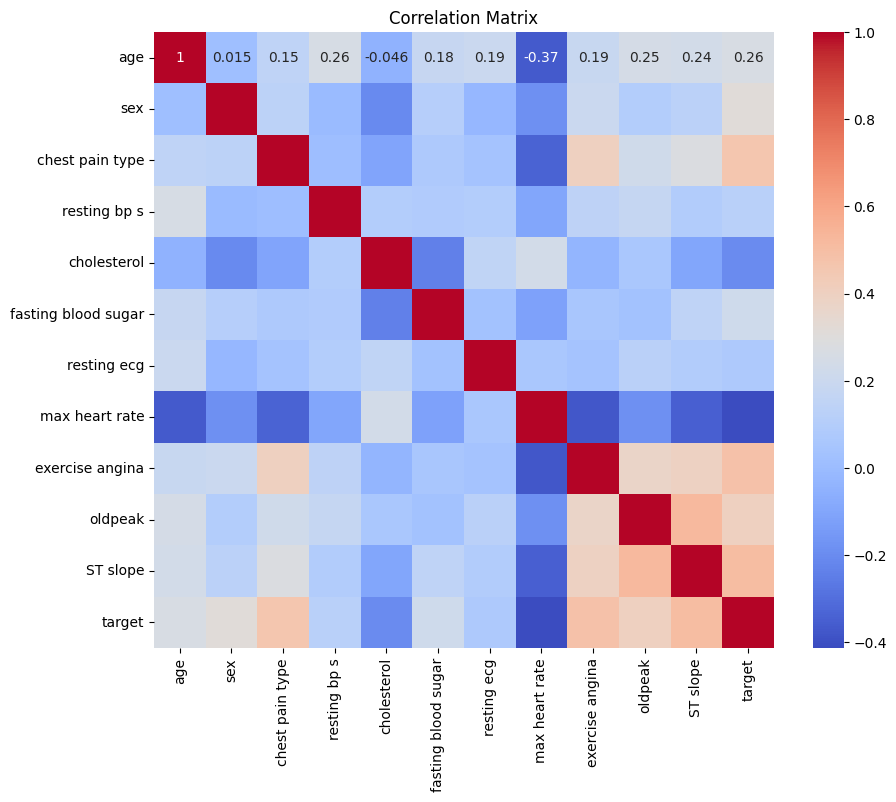

In [15]:
correlation_matrix=data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [16]:
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])
data.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,-1.466728,1,-1.318351,0.427328,0.775674,0,-0.802672,1.265039,0,-0.849792,-1.023217,0
1,-0.504600,0,-0.248932,1.516587,-0.299512,0,-0.802672,0.637758,0,0.071119,0.615583,1
2,-1.787437,1,-1.318351,-0.117301,0.716489,0,0.346762,-1.636136,0,-0.849792,-1.023217,0
3,-0.611503,0,0.820487,0.318402,0.035867,0,-0.802672,-1.244085,1,0.531575,0.615583,1
4,0.029915,1,-0.248932,0.971958,-0.151550,0,-0.802672,-0.695214,0,-0.849792,-1.023217,0


In [17]:
X=data.drop('target',axis=1)
y=data['target']
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# **CatBoost Model**

In [18]:
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42)
catboost_model.fit(x_train, y_train, verbose=False)

y_pred_catboost = catboost_model.predict(x_test)

In [19]:
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
print(f"CatBoost Accuracy: {accuracy_catboost}")
print(classification_report(y_test, y_pred_catboost))

CatBoost Accuracy: 0.9033613445378151
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       107
           1       0.89      0.94      0.91       131

    accuracy                           0.90       238
   macro avg       0.91      0.90      0.90       238
weighted avg       0.90      0.90      0.90       238



# **Feature Importance**

In [20]:
feature_importances = catboost_model.get_feature_importance(prettified=True)
print("Feature Importance (CatBoost):")
feature_importances

Feature Importance (CatBoost):


,Feature Id,Importances
0,ST slope,23.235937
1,chest pain type,15.740992
2,cholesterol,9.457310
3,sex,9.202181
4,oldpeak,8.440463
5,max heart rate,7.533140
6,age,7.113323
7,resting ecg,5.690166
8,resting bp s,5.083879
9,exercise angina,4.907964


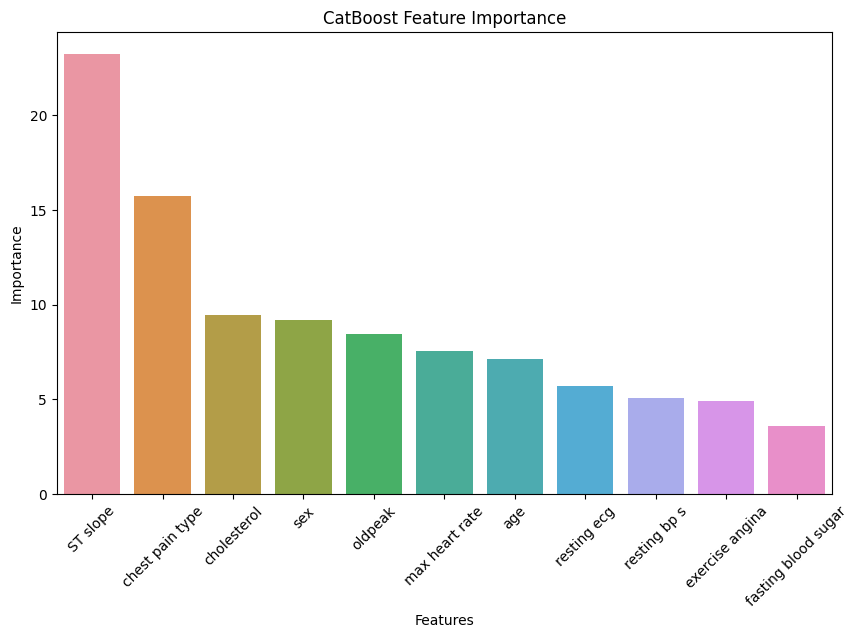

In [21]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature Id', y='Importances', data=feature_importances)
plt.xticks(rotation=45)
plt.title('CatBoost Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

# **Permutation Feature Importance**

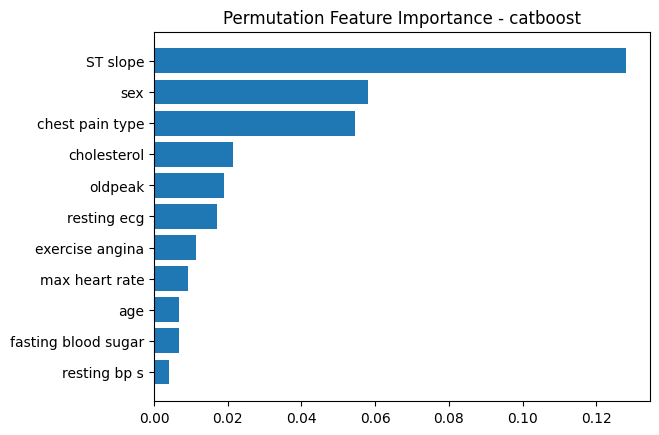

In [22]:
result = permutation_importance(catboost_model, x_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance - catboost")
plt.show()

# **SHAP**

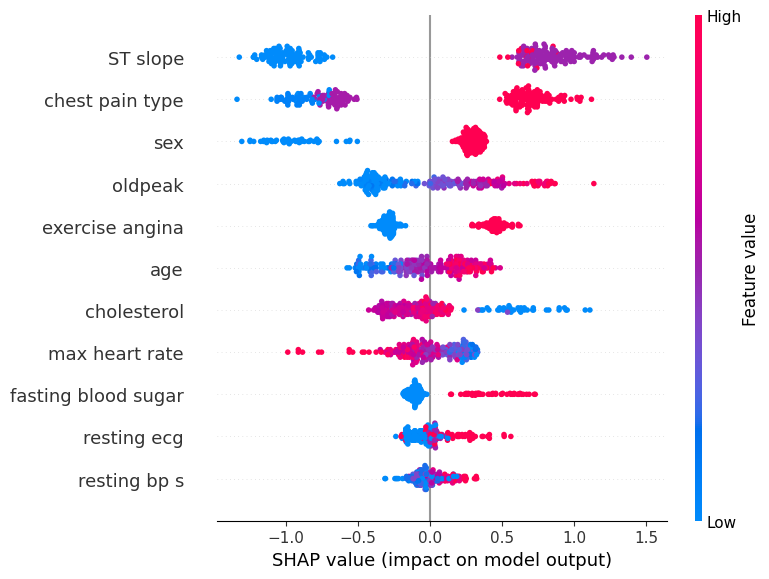

In [23]:
explainer = shap.Explainer(catboost_model)
shap_values = explainer(x_test)

#Summary Plot
shap.summary_plot(shap_values, x_test)

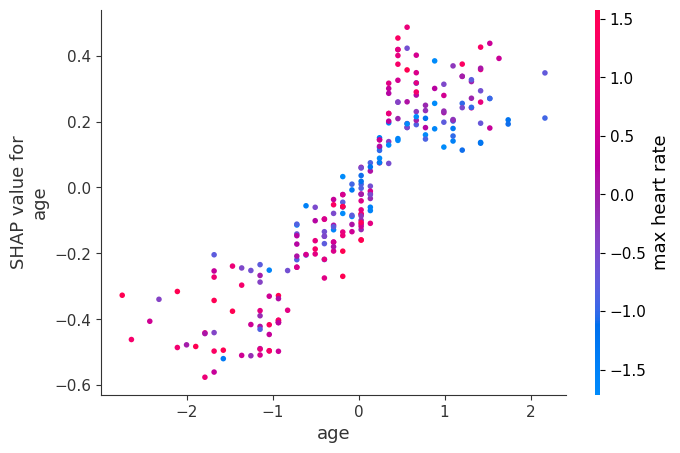

In [24]:
#Dependence Plot
shap.dependence_plot('age', shap_values.values, x_test)

# **H statistic**

In [26]:
random.seed(8)
X_exp = X.sample(n=100, replace=True, random_state=8)
h_stat = FriedmanHStatisticMethod()
h_stat.fit(catboost_model, X_exp)

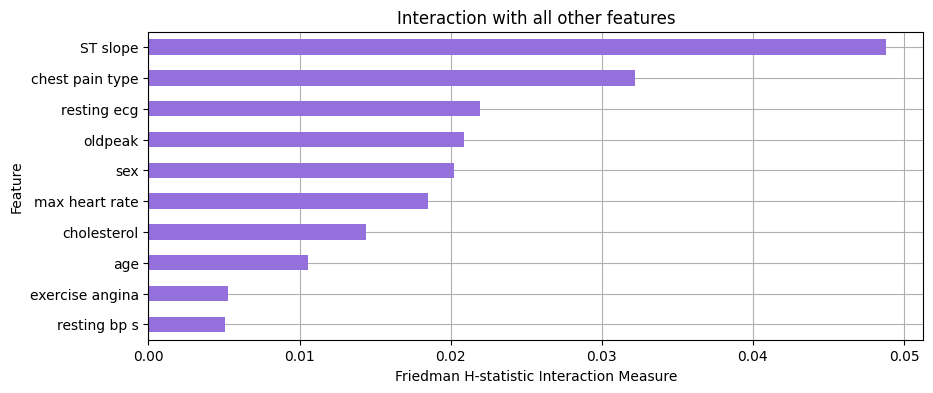

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot('bar_chart_ova',ax=ax)

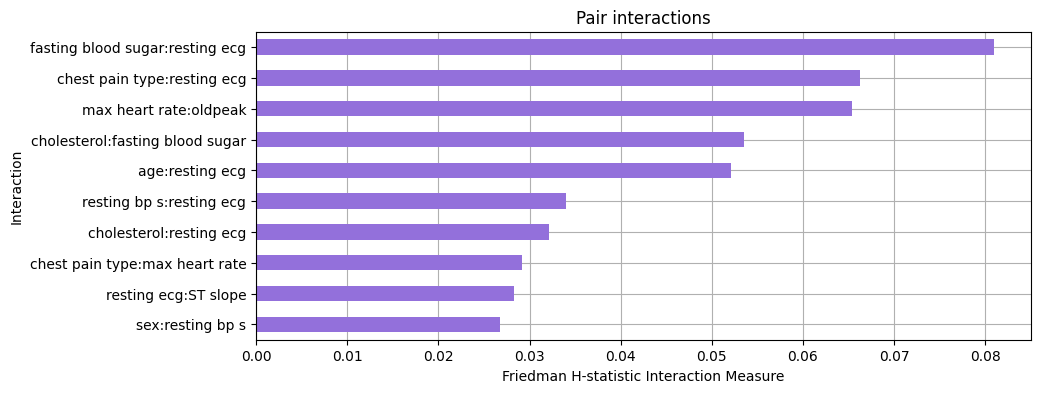

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))
h_stat.plot(vis_type='bar_chart',ax=ax)

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


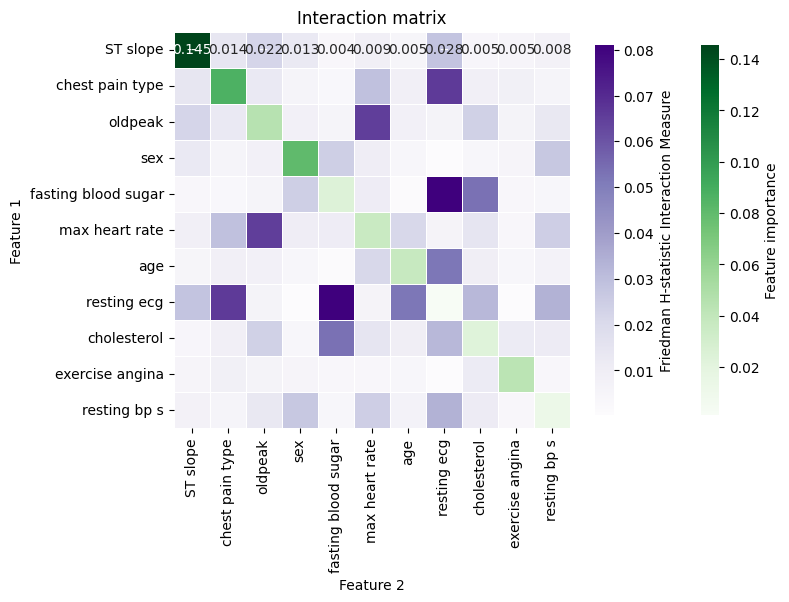

In [29]:
h_stat.plot()